# Objective - To rank potential talents sources using search keywords and re-rank when a candidate is starred

## Background

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Import relevant libraries

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
# scipy
from scipy.spatial.distance import cosine
# gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
# BERT
from sentence_transformers import SentenceTransformer
# random
import random
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
#import nltk
#nltk.download()


In [3]:
# Initial settings
pd.set_option('display.max_colwidth', None)
get_ipython().run_line_magic('matplotlib', 'inline')

# Exploratory Data Analysis

Exploring dataset to understand the data

In [4]:
# load the dataset
df = pd.read_csv('potential-talents.csv')

In [5]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [6]:
pt = df

In [7]:
# load the dataset
#pt = pd.read_csv('potential-talents.csv')

print("Shape of dataframe:", pt.shape)
pt.head()

Shape of dataframe: (104, 5)


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


Check for duplicate rows

In [8]:
# Drop fit column and explore duplicate rows
pt.drop('fit', axis = 1, inplace = True)             
pt_dup = pt.drop(['id'], axis = 1)                    
print("Number of duplicate entries:", pt_dup.duplicated().sum())                            

Number of duplicate entries: 51


In [9]:
# See duplicate entries
pt[pt_dup.duplicated(keep=False)]                     

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+
...,...,...,...,...
60,61,HR Senior Specialist,San Francisco Bay Area,500+
61,62,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+
62,63,Student at Chapman University,"Lake Forest, California",2
63,64,"SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR","Houston, Texas Area",500+


Number of duplicate rows are 51. We'll now remove duplicate entries.

In [10]:
# Drop duplicate rows and rebuild dataframe
pt_dup = pt_dup.drop_duplicates()                                    
pt = pd.concat([pt['id'], pt_dup], axis = 1).dropna(axis = 0)   
print("Shape of non-duplicated dataframe:", pt.shape)                                                         

Shape of non-duplicated dataframe: (53, 4)


We have now removed duplicate rows from the dataframe.

In [11]:
# Information about the dataframe
pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53 non-null     int64 
 1   job_title   53 non-null     object
 2   location    53 non-null     object
 3   connection  53 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [12]:
# Summary of the dataframe
pt.describe(include = 'all')

,id,job_title,location,connection
count,53.000000,53,53,53
unique,NaN,52,41,33
top,NaN,Aspiring Human Resources Professional,"Houston, Texas Area",500+
freq,NaN,2,4,18
mean,65.132075,NaN,NaN,NaN
std,35.117954,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,28.000000,NaN,NaN,NaN
50%,78.000000,NaN,NaN,NaN
75%,91.000000,NaN,NaN,NaN


There are no null values in the input columns. Total rows in the dataset are 53.

# Data cleaning

Clean data to make it easy to process and more robust

In [13]:
# Text normalization - Replace 'HR' by 'Human Resources' to make our model smarter
pt['cleaned_job_title'] = pt['job_title'].str.replace("HR", " Human Resources ")   

# Removing unnecssary characters like pipes, comma, dot etc. for cleaning the data.
pt['cleaned_job_title'] = pt['cleaned_job_title'].str.replace(r"[^a-zA-Z0-9\' ']", "")
pt['cleaned_job_title'] = pt['cleaned_job_title'].str.lower()
pt = pt.reset_index(drop = True)
pt.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college of business graduate magna cum laude and aspiring human resources professional
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher at epik english program in korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator at ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member at celal bayar university


In [14]:
# Remove stop words and lemmatize words in cleaned job title
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range (0, len(pt)):
    word_tokens = word_tokenize(pt['cleaned_job_title'][i])
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    lemmatized_sentence = []
    for word in filtered_sentence:
        lemmatized_sentence.append(lemmatizer.lemmatize(word))
    pt['cleaned_job_title'][i] = TreebankWordDetokenizer().detokenize(lemmatized_sentence)

pt.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university


# Vectorize job title using TF-IDF

Convert cleaned job titles into vectors 

In [15]:
# Convert job_title column into a list
job_title_list = list(pt['cleaned_job_title'])                    

# Vectorize job_title_list
vectorizer = TfidfVectorizer()                                 
vectorizer.fit(job_title_list)                    
X = vectorizer.transform(job_title_list)                   

In [16]:
job_title_list

['2019 ct bauer college business graduate magna cum laude aspiring human resource professional',
 'native english teacher epik english program korea',
 'aspiring human resource professional',
 'people development coordinator ryan',
 'advisory board member celal bayar university',
 'aspiring human resource specialist',
 'student humber college aspiring human resource generalist',
 'human resource senior specialist',
 'seeking human resource human resource generalist position',
 'student chapman university',
 'svp c human resource marketing communication csr officer engie houston woodland energy gp human resource sp human resource',
 'human resource coordinator intercontinental buckhead atlanta',
 'aspiring human resource management student seeking internship',
 'seeking human resource opportunity',
 'experienced retail manager aspiring human resource professional',
 'human resource staffing recruiting professional',
 'human resource specialist luxottica',
 'director human resource north

In [17]:
# Get feature names in all the documents
feature_names = vectorizer.get_feature_names()                  
print("Number of unique features: ", len(feature_names))        

Number of unique features:  177


In [18]:
# Convert job titles into arrays
tfidf_vector = X.toarray()                                  
print("Shape of Tfidf vector: ", tfidf_vector.shape)        

Shape of Tfidf vector:  (53, 177)


# Cosine Similarity

Calculate cosine similarity between document and the searched phrase

In [19]:
# Searched phrase
phrase = 'Aspiring human resources'

In [20]:
# Define cosine similarity function (cosine gives cosine distance)
def cosine_similarity(vector_1, vector_2):
    cos_sim = 1 - cosine(vector_1, vector_2)        
    return cos_sim

In [21]:
# Lemmatize searched phrase
lemmatized_phrase = []
tokenized_phrase = word_tokenize(phrase.lower())
for word in tokenized_phrase:
    lemmatized_phrase.append(lemmatizer.lemmatize(word))
lemmatized_phrase = TreebankWordDetokenizer().detokenize(lemmatized_phrase)

# Convert search phrase into a vector
X1 = vectorizer.transform([lemmatized_phrase])                    
X1_vector = X1.toarray()
print("Shape of search phrase vector:", X1_vector.shape)

Shape of search phrase vector: (1, 177)


In [22]:
# Calcualte Tfidf cosine similarity and add it to pt dataframe
sim_score_list = []
for x in range (0, len(pt)):
    sim_score_list.append(cosine_similarity(tfidf_vector[x], X1_vector))

pt['tfidf_sim_score'] = sim_score_list
pt.sort_values(by ='tfidf_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269


# Word Embedding

Word embedding "embeds" a word in a cluster of words based on how similar it is to all of the words in the cluster. We'll look at two types of word embedding models (GloVe and Word2Vec) and compute similarity scores between the searched phrase and the documents.

## a. GloVe (Global Vectors)

In GloVe, we measure the similarity of the hidden factors between words to predict their co-occurrence count. I am using a corpus from https://nlp.stanford.edu/projects/glove/ website.

In [23]:
#from gensim import models
#w = models.Word2Vec.load_word2vec_format('model', binary=True)
#w = models.KeyedVectors.load_word2vec_format('model', binary=True)

In [24]:
#from gensim.models import KeyedVectors

In [25]:
#import gensim.models.keyedvectors as word2vec

In [26]:
#embed_map = word2vec.KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)

In [27]:
#w = models.word2vec.KeyedVectors.load_word2vec_format('model', binary=True)

In [28]:
#print(w)

In [29]:
#from gensim.models.deprecated.keyedvectors import KeyedVectors, Vocab


In [30]:
%%time
# Create temp file and save converted embedding into it
target_file = get_tmpfile('word2vec.6B.300d.txt')
#target_file = get_tmpfile('word2vec.42B.300d.txt')
glove2word2vec('glove.6B.300d.txt', target_file) 
#glove2word2vec('glove.42B.300d.txt', target_file) 


# Load the converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('word2vec.6B.300d.bin.gz', binary=True)
#glove_model.save_word2vec_format('word2vec.42B.300d.bin.gz', binary=True)

CPU times: user 6min 32s, sys: 9.77 s, total: 6min 42s
Wall time: 6min 49s


In [31]:
# Define a function to vectorize a sentence's words
def doc_token_vectors(sentence, model, sentence_vector_list, vector_dimensions):
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
    
    for j in range(0, len(word_tokens)):
        if word_tokens[j] in filtered_words:
            token_vector = model[word_tokens[j]]
        else:
            token_vector = np.zeros(vector_dimensions)
        sentence_vector_list.append(token_vector)
    
    return sentence_vector_list

In [32]:
# Vectorize job title using GloVe model
glove_vectors = []
for i in range(0, len(pt)):
    glove_sentence_vector = []
    doc_token_vectors(pt['cleaned_job_title'][i], glove_model, glove_sentence_vector, 300)
    glove_vectors.append(glove_sentence_vector)

In [33]:
# Vectorize searched phrase using GloVe model
glove_search_phrase_vector = []
doc_token_vectors(lemmatized_phrase, glove_model, glove_search_phrase_vector, 300)

[array([ 3.4126e-02,  2.6860e-01,  4.7304e-01, -2.8189e-01,  4.5119e-02,
         6.2574e-01,  1.9627e-02, -5.4373e-01,  1.5018e-01,  5.5266e-01,
         3.2248e-01,  4.1528e-01,  4.6967e-01,  8.8021e-03, -1.7847e-01,
        -3.3880e-01, -1.5974e-01, -1.4349e-01,  3.4801e-01, -9.5154e-02,
        -4.8324e-01,  4.4225e-01,  1.1014e-01,  4.0039e-01, -1.6254e-01,
        -4.3039e-02,  3.8911e-01,  3.6974e-01,  1.3820e-02,  1.8999e-01,
         1.5572e-01, -4.4606e-01,  1.6935e-01, -2.4614e-01, -3.3605e-01,
         3.9507e-02, -4.6525e-01,  2.7791e-01,  7.4636e-01, -3.0076e-01,
         9.3199e-02, -6.7716e-02, -1.5919e-01,  3.0328e-02, -6.2353e-02,
         1.1201e-01,  1.7238e-01,  2.5729e-01,  3.7777e-01, -7.9195e-01,
         7.3877e-01, -6.2364e-01,  1.8464e-01, -3.9855e-02, -1.3531e-01,
         8.0921e-02, -1.2245e-01,  2.3747e-01,  8.1351e-02,  8.3093e-02,
        -1.9036e-03, -1.3692e-01,  4.1312e-01,  9.2847e-02, -7.0756e-02,
         2.8223e-01,  2.8092e-01, -1.2796e-04, -3.9

In [34]:
# Calculate cosine similarity between searched phrase and job title
glove_similarity =[]
for i in range(0, len(pt)):
    sim_score = cosine_similarity(np.mean(glove_vectors[i], axis = 0), np.mean(glove_search_phrase_vector, axis =0))
    glove_similarity.append(sim_score)

# Add GloVe similarity score to the pt dataframe
pt['GloVe_sim_score'] = glove_similarity
pt.sort_values(by ='GloVe_sim_score', ascending = False).head(15)

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.934877
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.924891
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.908395
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.871642
8,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,seeking human resource human resource generalist position,0.391072,0.850558
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.267743,0.837561
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.824088
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269,0.815054
49,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,human resource generalist loparex,0.228028,0.797933


## b. Word2vec

It is a popular word embedding technique using a 2-layer neural network.It works in a way such that a well-trained set of word vectors will place similar words close to each other in that space.

There are two main training algorithims within Word2Vec: Continuous Bag of Words(CBOW) and Skip-Gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. 

In [35]:
# Using a pre-trained word2vec model
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)

In [36]:
print(w2v_model)

In [37]:
#words = list(w2v_model.wv.vocab)
#print(w2v_model['ball'])


In [38]:
# Vectorize job title using Word2Vec model
w2v_vectors = []
for i in range(0, len(pt)):
    w2v_sentence_vector = []
    doc_token_vectors(pt['cleaned_job_title'][i], w2v_model, w2v_sentence_vector, 300)
    w2v_vectors.append(w2v_sentence_vector)

In [39]:
# Vectorize search phrase using Word2Vec model
w2v_search_phrase = []
doc_token_vectors(lemmatized_phrase, w2v_model, w2v_search_phrase, 300)

[array([-1.40625000e-01,  6.83593750e-02,  1.09252930e-02, -1.72851562e-01,
         1.35742188e-01,  2.55859375e-01,  3.78417969e-02,  4.22363281e-02,
        -4.27734375e-01,  1.05468750e-01,  4.24804688e-02,  6.78710938e-02,
         1.92382812e-01,  1.25732422e-02, -1.43554688e-01,  2.73437500e-01,
         1.30859375e-01,  2.48046875e-01,  4.73632812e-02, -2.97851562e-02,
         1.32812500e-01,  2.77343750e-01, -3.18359375e-01, -1.91406250e-01,
        -4.00390625e-02, -1.38549805e-02, -2.62451172e-03,  9.03320312e-02,
         9.13085938e-02,  2.08740234e-02,  1.93359375e-01, -1.52343750e-01,
        -3.83300781e-02, -7.12890625e-02,  3.78417969e-02, -8.25195312e-02,
         1.29882812e-01, -4.85839844e-02,  1.61132812e-01, -9.96093750e-02,
         2.49023438e-02, -1.13769531e-01, -9.33837891e-03, -1.46484375e-01,
        -1.22070312e-01,  6.88476562e-02, -1.98242188e-01,  2.26562500e-01,
         8.83789062e-02,  2.78320312e-02, -1.68945312e-01,  1.44531250e-01,
         1.6

In [40]:
# Calculate cosine similarity between searched phrase and job title
glove_similarity =[]
for i in range(0, len(pt)):
    sim_score = cosine_similarity(np.mean(glove_vectors[i], axis = 0), np.mean(glove_search_phrase_vector, axis =0))
    glove_similarity.append(sim_score)

# Add GloVe similarity score to the pt dataframe
pt['GloVe_sim_score'] = glove_similarity
pt.sort_values(by ='GloVe_sim_score', ascending = False).head(15)

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.934877
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.924891
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.908395
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.871642
8,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,seeking human resource human resource generalist position,0.391072,0.850558
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.267743,0.837561
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.824088
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269,0.815054
49,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,human resource generalist loparex,0.228028,0.797933


In [49]:
# Cosine Similarity score for Word2Vec model
w2v_similarity_score = []
for i in range(0, len(pt)):
    sim_score = cosine_similarity(np.mean(w2v_search_phrase, axis = 0), 
                                  np.mean(w2v_vectors[i], axis = 0))
    w2v_similarity_score.append(sim_score)

# Add Word2Vec similarity score
pt['Word2Vec_sim_score'] = w2v_similarity_score

# Calculate mean of Tfidf, Glove, Word2Vec and BERT similarity scores and add as a column in pt dataframe
pt['mean_sim_score'] = pt.loc[:, 'tfidf_sim_score': 'Word2Vec_sim_score'].mean(axis=1)
pt.sort_values(by = 'mean_sim_score', ascending = False).head()
pt.sort_values(by = 'mean_sim_score', ascending = False).head(15)

# BERT (Bidirectional Encoded Representations from Transformers)

BERT is a modern NLP technique developed by Google in 2018. It is used to solve a varierty of NLP problems including similarity of sentences. We'll use this technique to get similarity scores for our job title.

In [50]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [51]:
# Convert job titles into BERT embedded vectors
bert_job_title_embeddings = bert_model.encode(job_title_list)
bert_job_title_embeddings.shape

(53, 768)

In [52]:
bert_job_title_embeddings[0].shape

(768,)

In [53]:
# Convert search phrase into a BERT embedded vector
bert_search_phrase_embedding = bert_model.encode(lemmatized_phrase)
bert_search_phrase_embedding.shape

(768,)

In [54]:
# Calculate cosine similarity between job title and search phrase vectors
bert_cosine_similarity = []
for i in range(0, len(pt)):
    cos_sim = cosine_similarity(bert_job_title_embeddings[i], bert_search_phrase_embedding)
    bert_cosine_similarity.append(cos_sim)
    
# Add BERT_cosine_similarity column in the pt dataframe
pt['BERT_sim_score'] = bert_cosine_similarity
pt.sort_values(by = 'BERT_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.934877,0.912262,0.955138,0.869288
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.824088,0.827266,0.867910,0.723306
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.276993,0.785119,0.728513,0.849294,0.659979


In [55]:
# Calculate mean of Tfidf, Glove, Word2Vec and BERT similarity scores and add as a column in pt dataframe
pt['mean_sim_score'] = pt.loc[:, 'tfidf_sim_score': 'BERT_sim_score'].mean(axis=1)
pt.sort_values(by = 'mean_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.934877,0.912262,0.955138,0.869288
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.908395,0.875945,0.752413,0.786613
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.871642,0.874494,0.809261,0.738311


# Learning to Rank

Reranking our job titles when a candidate is starred

## Ranknet
Ranknet models target probabilities between two documents instead of their score for the same search keywords.

### Working of RankNet
1. A neural network with Linear, Dropout and activation layers is built which takes job title as input and returns a prediction.
2. Two random samples from the job titles are selected and their output is computed separately using forward propagation.
3. The cost, which is the difference between the two outputs is calculated and appropriate loss is calculated.
4. The loss is back-propogated to learn the selected example.
5. Steps 2-4 are repeated until the training is complete based on epochs.

In [56]:
pt_lr = pt.copy()

Supervised learning - Identifying candidates who are starred and updating their cosine similarity

In [57]:
star_candidate = input("Do you want to star any candidates? Enter 'Yes' or 'No': ")

starred = []
if star_candidate == 'Yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'Yes' or 'No': Yes
Enter ids of candidates you want to star (separated by space) : 3 97 82


In [58]:
pt.head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.236492,0.513324,0.592438,0.561626,0.475970
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea,0.000000,0.353147,0.240216,0.384784,0.244537
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,0.000000,0.451536,0.253594,0.746752,0.362970
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,0.000000,0.262758,0.206563,0.461810,0.232783


In [59]:
pt_lr['starred_score'] = pt_lr['mean_sim_score']
for id_num in starred:
    pt_lr.loc[pt_lr['id'] == id_num, 'starred_score'] = 1
pt_lr.head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score,starred_score
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.236492,0.513324,0.592438,0.561626,0.475970,0.475970
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea,0.000000,0.353147,0.240216,0.384784,0.244537,0.244537
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612,1.000000
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,0.000000,0.451536,0.253594,0.746752,0.362970,0.362970
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,0.000000,0.262758,0.206563,0.461810,0.232783,0.232783


In [60]:
random.seed(42)

In [61]:
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # Linear layer - linear projection
            nn.Dropout(0.5),                     # Regularization - Drops some of the neurons in a random fashion
            nn.LeakyReLU(0.2, inplace=True),     # Activation function - swap dropout and relu
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         # Applies a function on the output and brings the output bw 0 and 1. Softmax is replacemnet
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [62]:
random_row_1 = pt_lr.sample(n = 5000, replace = True)
random_row_2 = pt_lr.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['cleaned_job_title'])
job_title_list_ranknet2 = list(random_row_2['cleaned_job_title'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [63]:
y1 = list(random_row_1['starred_score'])
y2 = list(random_row_2['starred_score'])
y = torch.tensor([1.0 if y1_i>y2_i 
                  else 0.5 if y1_i==y2_i 
                  else 0.0 
                  for y1_i, y2_i in zip(y1, y2)]).float()
# y = torch.tensor([1.0 if y1_i/y2_i > 2 
#                   else 0.7 if y1_i/y2_i > 1.5
#                   else 0.6 if y1_i/y2_i > 1
#                   else 0.5 if y1_i/y2_i == 1 
#                   else 0.0 
#                   for y1_i, y2_i in zip(y1, y2)]).float()
y = y.unsqueeze(1)

In [64]:
rank_model = RankNet(num_feature = 768)
# optimizer = torch.optim.Adam(rank_model.parameters())         # experiment with optimizer
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)         # experiment with optimizer
loss_fun = torch.nn.BCELoss()             # BCE used for NLP problems

In [65]:
epoch = 2000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print(y1, y2, y, y_pred)
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6937927007675171
Epoch100, loss : 0.54825359582901
Epoch200, loss : 0.5139575600624084
Epoch300, loss : 0.5072693824768066
Epoch400, loss : 0.5039674639701843
Epoch500, loss : 0.5033411383628845
Epoch600, loss : 0.5030197501182556
Epoch700, loss : 0.5032989978790283
Epoch800, loss : 0.5029616951942444
Epoch900, loss : 0.5018026232719421
Epoch1000, loss : 0.5023621916770935
Epoch1100, loss : 0.5032079219818115
Epoch1200, loss : 0.5023825764656067
Epoch1300, loss : 0.5024844408035278
Epoch1400, loss : 0.5028627514839172
Epoch1500, loss : 0.5020499229431152
Epoch1600, loss : 0.5015619993209839
Epoch1700, loss : 0.5019335746765137
Epoch1800, loss : 0.5019972920417786
Epoch1900, loss : 0.5019477605819702


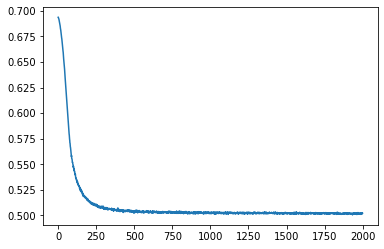

In [66]:
import matplotlib.pyplot as plt

x = list(range(2000))
plt.plot(x, losses)

In [67]:
pred_score = []
for i in range(len(pt_lr)):
    embedding = bert_model.encode([pt_lr['cleaned_job_title'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    pred_score.append(pred)

pt_lr['RankNet_score'] = pred_score
pt_lr.sort_values(by ='starred_score', ascending = False)

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score,starred_score,RankNet_score
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.824088,0.827266,0.867910,0.723306,1.000000,1.00
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612,1.000000,1.00
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.924891,0.950395,0.948828,0.897612,1.000000,1.00
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.934877,0.912262,0.955138,0.869288,0.869288,1.00
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.908395,0.875945,0.752413,0.786613,0.786613,1.00
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.871642,0.874494,0.809261,0.738311,0.738311,1.00
8,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,seeking human resource human resource generalist position,0.391072,0.850558,0.815463,0.775801,0.708223,0.708223,0.99
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269,0.815054,0.783973,0.702358,0.682414,0.682414,1.00
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.267743,0.837561,0.756767,0.841447,0.675880,0.675880,1.00
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,student humber college aspiring human resource generalist,0.390565,0.738099,0.829068,0.712709,0.667610,0.667610,1.00


In [68]:
import fasttext

In [ ]:
fasttext_model = fasttext.train_unsupervised('wiki-news-300d-1M.vec', model='cbow')
print (fasttext_model.words(10)) # list of words in dictionary

Read 301M words
Number of words:  18483
Number of labels: 0


Progress:   2.8% words/sec/thread:   16468 lr:  0.048617 avg.loss:  2.635486 ETA:   8h15m18s

Progress:   6.0% words/sec/thread:   16616 lr:  0.046989 avg.loss:  2.666616 ETA:   7h54m27s  2.8% words/sec/thread:   16479 lr:  0.048598 avg.loss:  2.634231 ETA:   8h14m45s  2.8% words/sec/thread:   16480 lr:  0.048597 avg.loss:  2.634183 ETA:   8h14m43s  2.8% words/sec/thread:   16487 lr:  0.048590 avg.loss:  2.633746 ETA:   8h14m27s  2.9% words/sec/thread:   16501 lr:  0.048567 avg.loss:  2.632267 ETA:   8h13m47s  3.0% words/sec/thread:   16532 lr:  0.048516 avg.loss:  2.629193 ETA:   8h12m21s  3.0% words/sec/thread:   16533 lr:  0.048514 avg.loss:  2.629081 ETA:   8h12m18s  3.0% words/sec/thread:   16535 lr:  0.048508 avg.loss:  2.628718 ETA:   8h12m10s  3.0% words/sec/thread:   16547 lr:  0.048496 avg.loss:  2.628011 ETA:   8h11m42s  3.0% words/sec/thread:   16553 lr:  0.048481 avg.loss:  2.637233 ETA:   8h11m21s  3.1% words/sec/thread:   16555 lr:  0.048471 avg.loss:  2.645213 ETA:   8h11m12s  3.1% words/sec/thread:   16563 lr:  0.048459 avg.loss:  2.653903 ETA:   8h10m51s  3.1%

Progress:   8.7% words/sec/thread:   16498 lr:  0.045637 avg.loss:  1.923869 ETA:   7h44m 5s  6.0% words/sec/thread:   16616 lr:  0.046988 avg.loss:  2.665603 ETA:   7h54m25s  6.1% words/sec/thread:   16616 lr:  0.046967 avg.loss:  2.649214 ETA:   7h54m13s  6.1% words/sec/thread:   16616 lr:  0.046960 avg.loss:  2.643592 ETA:   7h54m 9s  6.2% words/sec/thread:   16621 lr:  0.046906 avg.loss:  2.602187 ETA:   7h53m28s  6.2% words/sec/thread:   16622 lr:  0.046897 avg.loss:  2.594988 ETA:   7h53m20s  6.2% words/sec/thread:   16615 lr:  0.046876 avg.loss:  2.579557 ETA:   7h53m20s  6.3% words/sec/thread:   16616 lr:  0.046874 avg.loss:  2.578020 ETA:   7h53m17s  6.3% words/sec/thread:   16616 lr:  0.046865 avg.loss:  2.571362 ETA:   7h53m11s  6.3% words/sec/thread:   16610 lr:  0.046849 avg.loss:  2.559808 ETA:   7h53m12s  6.4% words/sec/thread:   16611 lr:  0.046820 avg.loss:  2.538728 ETA:   7h52m52s  6.4% words/sec/thread:   16615 lr:  0.046794 avg.loss:  2.520584 ETA:   7h52m30s  6.4%

In [ ]:
fasttext_model.save_model("fasttext_cbow.bin")

In [ ]:
mode_load = fasttext.load_model("fasttext_cbow.bin")

In [ ]:
model_load

In [ ]:
fasttext_model

In [ ]:
len(fasttext_model.words)

In [ ]:
len(model_load.words)

In [ ]:
model_load['king']

In [ ]:
fasttext_model['human']

In [ ]:
#from gensim.models.wrappers import Fasttext

#model = FastText.load_fasttext_format('wiki.simple')

# Conclusion

We have illustrated the ability to source pre-trained Natural Language Processing vectors, which use various methods and strategies for measuring "similarity". Further, we employed a basic Learning To Rank model in order to incorporate feedback to the data search. Given the small dataset that appears to be targeted for a specific "search phrase", we can use the re-ranking results to reveal patterns of relationships, and find other candidates who score better under different comparisons. The feedback loop is somewhat circuitous, as starring a candidate is just one additional data point to be considered in the machine learning model. In order to enhance the results, we can append additional info to the comparison vectors, such as the geographic location and number of connections fields provided in the dataset. In other words, the model will eventually learn to identify the additional sub-vectors and their meaning. 

Switching the search phrase from "Aspiring human resources" to "full-stack software engineer" reveals that very few entries in the dataset are relevant for the latter search, based on an observed lack of similar words in the job titles. This reveals a feature of how the comparison can be used, since we can anticipate some roles with a generic job title will require additional data points to distinguish multiple duplicates or virtual ties in the rankings. In the sample test case, we can infer that "aspiring" in the search term both limits the number of similarities, and implies a certain low experience level.

